### Instructions

Your case study is to build a classifier using logistic regression to predict hospital readmittance. 
There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

### Team:
- Dylan Scott
- Jobin Joseph
- Taylor Bonar
- Satvik Ajmera

## EDA

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
diabetes_df = pd.read_csv("../dataset_diabetes/diabetic_data.csv", header=0, na_values="?")
diabetes_df.head()

C:\Users\Taylo\AppData\Local\Temp\ipykernel_29284\2147206719.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetes_df = pd.read_csv("../dataset_diabetes/diabetic_data.csv", header=0, na_values="?")


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
diabetes_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


### Missing Data Inspection

In [5]:
import missingno

<AxesSubplot:>

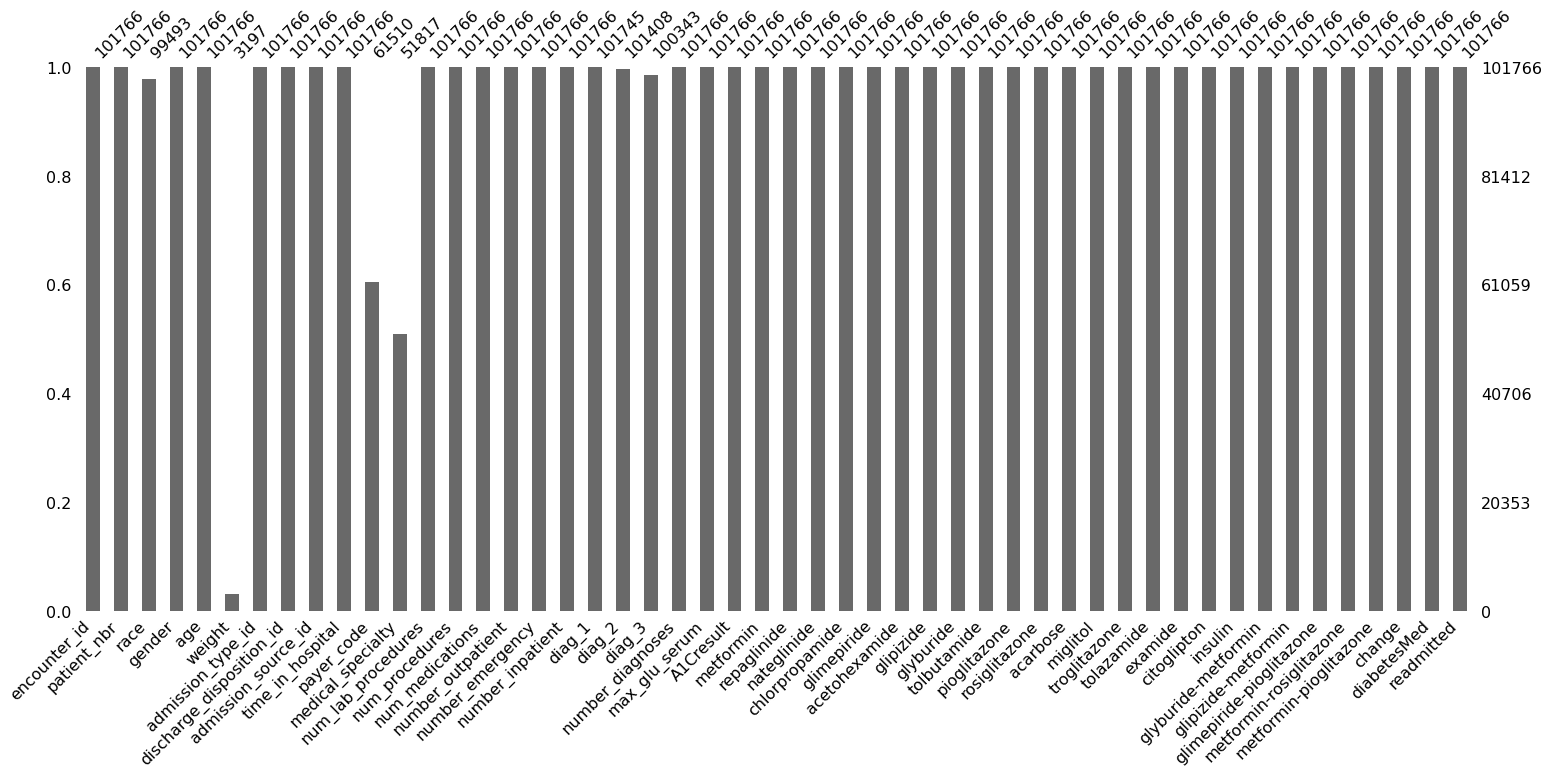

In [6]:
missingno.bar(diabetes_df)

By using missingno.bar() we can check what fields appear to have missing data. As it appears, we have three variables with missing values (from least to most missing):
* race
* payer_code
* medical_specialty
* weight

We'll need to handle missing data, however, due to the large volume of data missing for weigh, we may need to exclude such data.

But first, let's see if we can find any patterns of missing data via the dendrogram with our fields.

<AxesSubplot:>

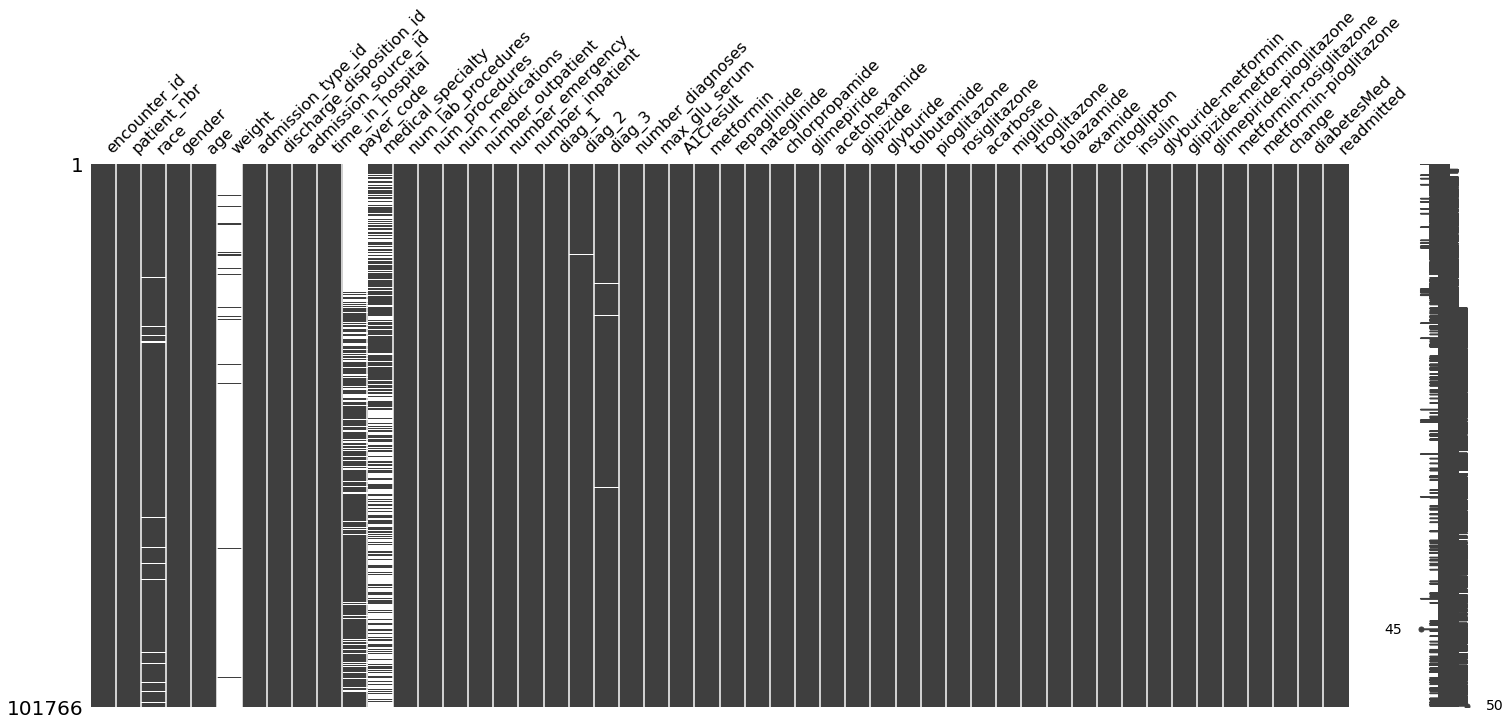

In [9]:
missingno.matrix(diabetes_df)

Text(0.5, 1.0, 'Missing Data per Patient')

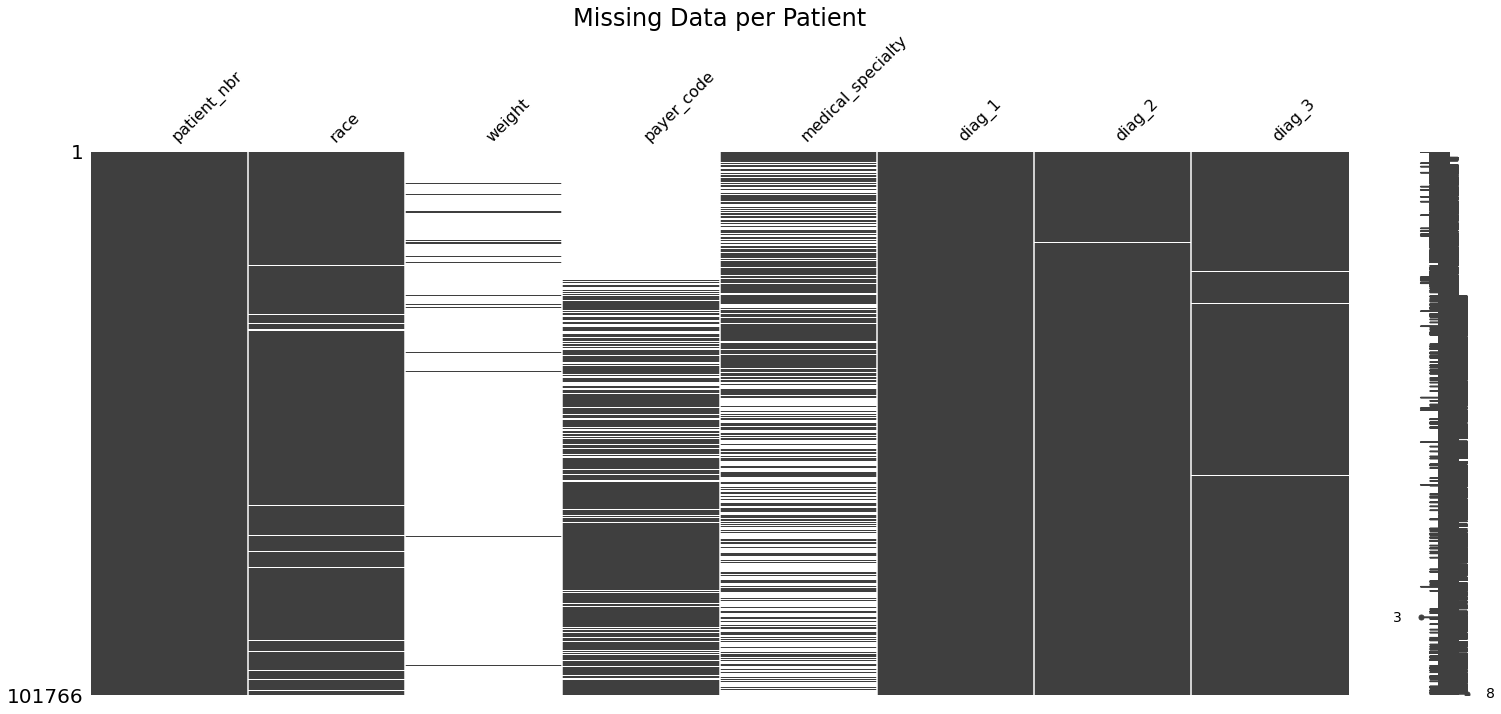

In [17]:
missingno.matrix(diabetes_df[["patient_nbr","race", "weight", "payer_code","medical_specialty", "diag_1","diag_2","diag_3"]])

font1 = {'color':'black','size':24}
plt.title("Missing Data per Patient", fontdict=font1)

Here, we used missingno.matrix to visualize how rows and the missing data might map out to see if there are any potential patterns we can discern.

We can see that medical_specialty is missing at random, while payer_code may be a smaller subset tied to medical_specialty when missing. So let's generate a dendogram to confirm our suspicions.

<AxesSubplot:>

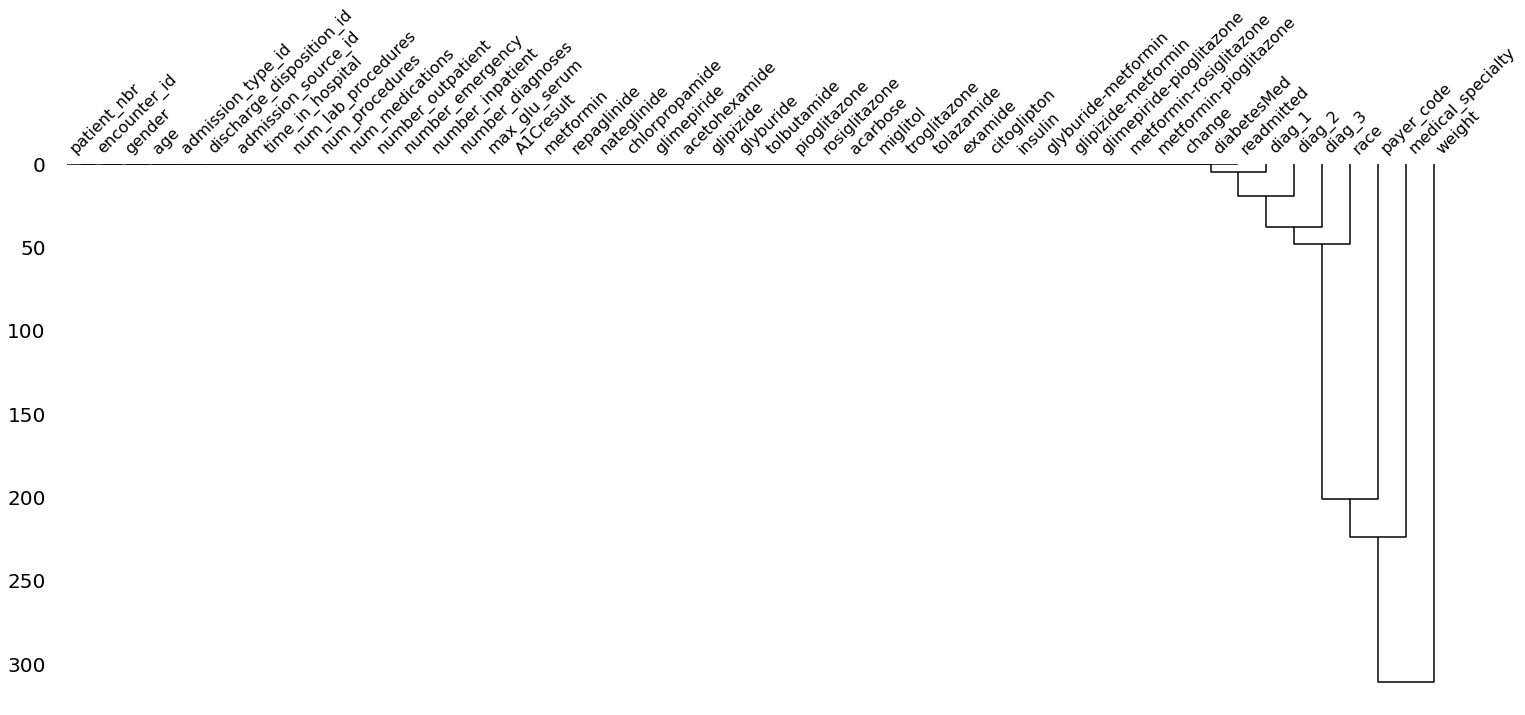

In [7]:
missingno.dendrogram(diabetes_df)

With the dendrogram, we can map out fields that are missing together and find their pattern of apperance with one another. We can see the following pairs (from most missing associations, to least missing associations):
* weight + medical specialty
* the previous associations + payer code
* the previous associations + race
* the previous associations + diag_3
* the previous associations + diag_2
* the previous associations + diag_1
* the previous associations + readmittance

However, after payer code with all previous associations, we can see a dramatic decrease in our missing data. We'll need to examine how to handle possible missing data for those combinations minimally. Is the data missing at random, completely random, or x?